In [ ]:
!pip install pyspark==3.0.1 py4j==0.10.9

# 1. Загрузить данные из файлов Fertility.csv, Life_Table1.csv, Life_Table2.csv, Population.csv, Population2.csv, Population3.csv, Population4.csv, Population5.csv. Например: http://intersyn.net/Population.csv. Описание некоторых переменных можно найти на сайте:https://www.kaggle.com/datasets/joebeachcapital/world-population-data/data



Импорт нужных библиотек

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import min, mean, max, count, sum
from pyspark.sql.types import FloatType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

Создаём спарк-сессию с нашим именем и выделяем ему память через контекст

In [ ]:
sc = SparkContext(conf=SparkConf().setAppName("Praktika PySpark"). set("spark.executor.memory", "4g"))
spark = SparkSession(sc)
spark

Данные очень большие, поэтому лучше считать их в PySpark, так как датасеты Popultaion и Life_table имеют одинаковую схему, можно считать их в один большой датафрейм

In [ ]:
pop = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .option("inferSchema", "true")\
        .load('/content/Pop*.csv')
pop.show()

+---------+-----+-----+---------+---------+---------+---------+-----------+--------+--------+-----+-------+----+---------+------+-----------+----------+----------+----------+----------+
|SortOrder|LocID|Notes|ISO3_code|ISO2_code|SDMX_code|LocTypeID|LocTypeName|ParentID|Location|VarID|Variant|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|   PopMale| PopFemale|  PopTotal|
+---------+-----+-----+---------+---------+---------+---------+-----------+--------+--------+-----+-------+----+---------+------+-----------+----------+----------+----------+----------+
|        1|  900| null|     null|     null|        1|        1|      World|       0|   World|    3|   High|2022|     2022|   0-4|          0|         5|342903.908| 324258.25|667162.158|
|        1|  900| null|     null|     null|        1|        1|      World|       0|   World|    3|   High|2022|     2022|   5-9|          5|         5|353020.746|331676.536|684697.282|
|        1|  900| null|     null|     null|        1|        1|      W

In [ ]:
life = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .option("inferSchema", "true")\
        .load('/content/Life*.csv')
life.show()

+---------+-----+-----+---------+---------+---------+---------+-----------+--------+--------+-----+-------+----+---------+-----+-----+------+-----------+----------+----------+----------+----------+---------+--------+---------+----------+-----------+-------+--------+
|SortOrder|LocID|Notes|ISO3_code|ISO2_code|SDMX_code|LocTypeID|LocTypeName|ParentID|Location|VarID|Variant|Time|MidPeriod|SexID|  Sex|AgeGrp|AgeGrpStart|AgeGrpSpan|        mx|        qx|        px|     lx22|      dx|     Lx24|        Sx|         Tx|     ex|      ax|
+---------+-----+-----+---------+---------+---------+---------+-----------+--------+--------+-----+-------+----+---------+-----+-----+------+-----------+----------+----------+----------+----------+---------+--------+---------+----------+-----------+-------+--------+
|      1.0|900.0| null|     null|     null|        1|      1.0|      World|       0|   World|    2| Medium|2022|   2022.5|    3|Total|     0|          0|         1|0.02817405|0.02752829|0.97247171|  

In [ ]:
fer = spark.read.format("csv")\
        .option("header", "true")\
        .option("delimiter", ",")\
        .option("inferSchema", "true")\
        .load('/content/Fertility.csv')
fer.show()

+---------+-----+-----+---------+---------+---------+---------+-----------+--------+--------+-----+-------+----+---------+------+-----------+----------+-------+-----+--------+
|SortOrder|LocID|Notes|ISO3_code|ISO2_code|SDMX_code|LocTypeID|LocTypeName|ParentID|Location|VarID|Variant|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|   ASFR|PASFR|  Births|
+---------+-----+-----+---------+---------+---------+---------+-----------+--------+--------+-----+-------+----+---------+------+-----------+----------+-------+-----+--------+
|        1|  900| null|     null|     null|        1|        1|      World|     0.0|   World|    2| Medium|1950|   1950.5|    15|       15.0|         1| 30.809|0.634| 747.345|
|        1|  900| null|     null|     null|        1|        1|      World|     0.0|   World|    2| Medium|1950|   1950.5|    16|       16.0|         1|  56.11|1.155|1331.786|
|        1|  900| null|     null|     null|        1|        1|      World|     0.0|   World|    2| Medium|1950|   1950.

# 2. Исключить переменные, смысл которых не ясен. Провести статистический анализ данных для страны, которую Вы использовали во второй аттестационной работе. Обязательно использовать графики, группировку. Сделать выводы. Использовать данные из всех файлов.

Посмотрим на информацию о столбцах более детально

In [ ]:
pop.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+
|summary|         SortOrder|             LocID|             Notes|         ISO3_code|           ISO2_code|         SDMX_code|           LocTypeID|       LocTypeName|            ParentID|          Location|             VarID|           Variant|              Time|         MidPeriod|            AgeGrp|         AgeGrpStart|        AgeGrpSpan|          PopMale|        PopFemale|         PopTotal|
+-------+------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+-----

In [ ]:
life.describe().show()

+-------+-----------------+------------------+----------------+--------------------+------------------+------------------+-----------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+--------------------+------------------+-----------------+------------------+-----------------+--------------------+------------------+
|summary|        SortOrder|             LocID|           Notes|           ISO3_code|         ISO2_code|         SDMX_code|        LocTypeID|LocTypeName|          ParentID|          Location|             VarID|           Variant|              Time|         MidPeriod|             SexID|               Sex|            AgeGrp|       AgeGrpStart|        AgeGrpSpan|                 mx|                qx|                px|                lx22|     

In [ ]:
fer.describe().show()

+-------+------------------+------------------+------------------+-----------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|summary|         SortOrder|             LocID|             Notes|        ISO3_code|           ISO2_code|           SDMX_code|         LocTypeID|       LocTypeName|          ParentID|         Location|               VarID|          Variant|              Time|         MidPeriod|            AgeGrp|       AgeGrpStart|        AgeGrpSpan|             ASFR|            PASFR|            Births|
+-------+------------------+------------------+------------------+-----------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+-----------------

In [ ]:
pop.printSchema()

root
 |-- SortOrder: string (nullable = true)
 |-- LocID: string (nullable = true)
 |-- Notes: string (nullable = true)
 |-- ISO3_code: string (nullable = true)
 |-- ISO2_code: string (nullable = true)
 |-- SDMX_code: string (nullable = true)
 |-- LocTypeID: string (nullable = true)
 |-- LocTypeName: string (nullable = true)
 |-- ParentID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- MidPeriod: string (nullable = true)
 |-- AgeGrp: string (nullable = true)
 |-- AgeGrpStart: string (nullable = true)
 |-- AgeGrpSpan: string (nullable = true)
 |-- PopMale: string (nullable = true)
 |-- PopFemale: string (nullable = true)
 |-- PopTotal: string (nullable = true)



In [ ]:
life.printSchema()

root
 |-- SortOrder: double (nullable = true)
 |-- LocID: double (nullable = true)
 |-- Notes: string (nullable = true)
 |-- ISO3_code: string (nullable = true)
 |-- ISO2_code: string (nullable = true)
 |-- SDMX_code: string (nullable = true)
 |-- LocTypeID: double (nullable = true)
 |-- LocTypeName: string (nullable = true)
 |-- ParentID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- MidPeriod: string (nullable = true)
 |-- SexID: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeGrp: string (nullable = true)
 |-- AgeGrpStart: string (nullable = true)
 |-- AgeGrpSpan: string (nullable = true)
 |-- mx: string (nullable = true)
 |-- qx: string (nullable = true)
 |-- px: string (nullable = true)
 |-- lx22: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- Lx24: string (nullable = true)
 |-- Sx: string (nullable = true)
 |-

In [ ]:
fer.printSchema()

root
 |-- SortOrder: string (nullable = true)
 |-- LocID: string (nullable = true)
 |-- Notes: string (nullable = true)
 |-- ISO3_code: string (nullable = true)
 |-- ISO2_code: string (nullable = true)
 |-- SDMX_code: string (nullable = true)
 |-- LocTypeID: string (nullable = true)
 |-- LocTypeName: string (nullable = true)
 |-- ParentID: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- MidPeriod: string (nullable = true)
 |-- AgeGrp: string (nullable = true)
 |-- AgeGrpStart: double (nullable = true)
 |-- AgeGrpSpan: string (nullable = true)
 |-- ASFR: double (nullable = true)
 |-- PASFR: string (nullable = true)
 |-- Births: double (nullable = true)



Столбцы 'Notes', 'ISO2_code' и 'ISO3_code' содержат очень мало информации, много пропусков, можно их смело удалить

In [ ]:
columns_to_drop = ['Notes', 'ISO2_code', 'ISO3_code']
fer = fer.drop(*columns_to_drop)
life = life.drop(*columns_to_drop)
pop = pop.drop(*columns_to_drop)

Так как данных очень много, попробуем посмотреть на маленькую случайную выборку

In [ ]:
fer.sample(0.0001).collect()

[Row(SortOrder='1', LocID='900', SDMX_code='1', LocTypeID='1', LocTypeName='World', ParentID=0.0, Location='World', VarID='8', Variant='Constant mortality', Time='2066', MidPeriod='2066.5', AgeGrp='31', AgeGrpStart=31.0, AgeGrpSpan='1', ASFR=113.162, PASFR='5.651', Births=7036.477),
 Row(SortOrder='1', LocID='900', SDMX_code='1', LocTypeID='1', LocTypeName='World', ParentID=0.0, Location='World', VarID='9', Variant='No change', Time='2079', MidPeriod='2079.5', AgeGrp='47', AgeGrpStart=47.0, AgeGrpSpan='1', ASFR=8.579, PASFR='0.25', Births=546.908),
 Row(SortOrder='1', LocID='900', SDMX_code='1', LocTypeID='1', LocTypeName='World', ParentID=0.0, Location='World', VarID='9', Variant='No change', Time='2079', MidPeriod='2079.5', AgeGrp='23', AgeGrpStart=23.0, AgeGrpSpan='1', ASFR=175.754, PASFR='5.115', Births=15319.852),
 Row(SortOrder='1', LocID='900', SDMX_code='1', LocTypeID='1', LocTypeName='World', ParentID=0.0, Location='World', VarID='10', Variant='Momentum', Time='2074', MidPerio

In [ ]:
life.sample(0.00001).collect()

[Row(SortOrder=7.0, LocID=1830.0, SDMX_code='419', LocTypeID=12.0, LocTypeName='SDG region', ParentID='1828', Location='Latin America and the Caribbean', VarID='2', Variant='Medium', Time='2055', MidPeriod='2055.5', SexID='3', Sex='Total', AgeGrp='20-20', AgeGrpStart='20', AgeGrpSpan='1', mx='0.00053784', qx='0.00053769', px='0.99946231', lx22='99060.057', dx='53.264', Lx24='99033.425', Sx='0.99948885', Tx='6156985.755', ex='62.1541', ax='0.5'),
 Row(SortOrder=16.0, LocID=948.0, SDMX_code=None, LocTypeID=5.0, LocTypeName='Development group', ParentID='1803', Location='Less developed regions, excluding China', VarID='2', Variant='Medium', Time='2095', MidPeriod='2095.5', SexID='3', Sex='Total', AgeGrp='97-97', AgeGrpStart='97', AgeGrpSpan='1', mx='0.22299444', qx='0.20062528', px='0.79937472', lx22='10063.734', dx='2019.039', Lx24='9054.215', Sx='0.80894584', Tx='36531.35', ex='3.63', ax='0.5'),
 Row(SortOrder=21.0, LocID=1517.0, SDMX_code=None, LocTypeID=13.0, LocTypeName='Income group

In [ ]:
pop.sample(0.00001).collect()

[Row(SortOrder='4', LocID='1833', SDMX_code='747', LocTypeID='12', LocTypeName='SDG region', ParentID='1828', Location='Northern Africa and Western Asia', VarID='5', Variant='Constant fertility', Time='2070', MidPeriod='2070', AgeGrp='75-79', AgeGrpStart='75', AgeGrpSpan='5', PopMale='13308.475', PopFemale='15173.895', PopTotal='28482.37'),
 Row(SortOrder='6', LocID='1832', SDMX_code='753', LocTypeID='12', LocTypeName='SDG region', ParentID='1828', Location='Eastern and South-Eastern Asia', VarID='4', Variant='Low', Time='2033', MidPeriod='2033', AgeGrp='90-94', AgeGrpStart='90', AgeGrpSpan='5', PopMale='3368.577', PopFemale='7257.55', PopTotal='10626.127'),
 Row(SortOrder='12', LocID='901', SDMX_code='514', LocTypeID='5', LocTypeName='Development group', ParentID='1803', Location='More developed regions', VarID='10', Variant='Momentum', Time='2049', MidPeriod='2049', AgeGrp='95-99', AgeGrpStart='95', AgeGrpSpan='5', PopMale='1468.127', PopFemale='3478.316', PopTotal='4946.443'),
 Row(

Посмотрим на value_counts на самом маленьком датафрейме переведя в пандас и напишем свой аналог под PySpark

In [ ]:
fer.toPandas()['LocTypeName'].value_counts()

SDG region           438476
Development group     49086
World                 41647
5.23                      1
43                        1
Momentum                  1
2059                      1
Name: LocTypeName, dtype: int64

In [ ]:
fer.groupBy('LocTypeID').count().orderBy('count').collect()

[Row(LocTypeID='High', count=1),
 Row(LocTypeID='134.556', count=1),
 Row(LocTypeID='136.865', count=1),
 Row(LocTypeID=None, count=1),
 Row(LocTypeID='43', count=1),
 Row(LocTypeID='10', count=1),
 Row(LocTypeID='1', count=41647),
 Row(LocTypeID='5', count=49086),
 Row(LocTypeID='12', count=438476)]

In [ ]:
pop.groupBy('LocTypeID').count().orderBy('count').collect()

[Row(LocTypeID='2069', count=1),
 Row(LocTypeID='High', count=1),
 Row(LocTypeID='2058', count=1),
 Row(LocTypeID=' excluding least developed countries"', count=1),
 Row(LocTypeID='85', count=1),
 Row(LocTypeID='35', count=1),
 Row(LocTypeID='2036', count=1),
 Row(LocTypeID='80-84', count=1),
 Row(LocTypeID='SDG region', count=1),
 Row(LocTypeID='5278.163', count=1),
 Row(LocTypeID='90-94', count=1),
 Row(LocTypeID='219131.929', count=1),
 Row(LocTypeID='307280.347', count=1),
 Row(LocTypeID='2068', count=1),
 Row(LocTypeID='144087.239', count=1),
 Row(LocTypeID='2067', count=1),
 Row(LocTypeID='25-29', count=1),
 Row(LocTypeID=None, count=3),
 Row(LocTypeID='2', count=22523),
 Row(LocTypeID='1', count=56778),
 Row(LocTypeID='3', count=58883),
 Row(LocTypeID='13', count=340465),
 Row(LocTypeID='5', count=574742),
 Row(LocTypeID='12', count=583256),
 Row(LocTypeID='4', count=615148)]

In [ ]:
life.groupBy('LocTypeID').count().orderBy('count').collect()

[Row(LocTypeID=None, count=1),
 Row(LocTypeID=0.5, count=2),
 Row(LocTypeID=1.0, count=15252),
 Row(LocTypeID=3.0, count=23230),
 Row(LocTypeID=2.0, count=23231),
 Row(LocTypeID=4.0, count=63121),
 Row(LocTypeID=13.0, count=139380),
 Row(LocTypeID=5.0, count=162609),
 Row(LocTypeID=12.0, count=181555)]

Как видим, в датасете Population данные идут невпопад, попадаются строчки, где вместо ID прописан Name, попробуем привести данные в порядом, удалим все ненужные строчки в датасетах и посмотрим вновь на данные, возможно поменяем тип столбцов и тогда группировку будет делать более правильно , а также удалим nan - значения, в таких больших датасетах, они нам не нужны

In [ ]:
life = life.dropna()

In [ ]:
pop = pop.dropna()

In [ ]:
fer = fer.dropna()

После удаления nan - значений, некорректные значения автоматически ушли

In [ ]:
fer.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------+--------------------+--------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|         SortOrder|             LocID|         SDMX_code|         LocTypeID|      LocTypeName|          ParentID|      Location|               VarID|       Variant|              Time|         MidPeriod|            AgeGrp|      AgeGrpStart|        AgeGrpSpan|             ASFR|             PASFR|            Births|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------+--------------------+--------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|            529195|

In [ ]:
life.describe().show()

+-------+------------------+-----------------+------------------+-----------------+------------+------------------+--------+-------+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+------------------+--------------------+------------------+
|summary|         SortOrder|            LocID|         SDMX_code|        LocTypeID| LocTypeName|          ParentID|Location|  VarID|Variant|              Time|        MidPeriod|             SexID|               Sex|            AgeGrp|       AgeGrpStart|        AgeGrpSpan|                  mx|                qx|                 px|              lx22|               dx|             Lx24|                Sx|                Tx|                  ex|                ax|
+-------+------------------+-----------------+------------------+---

In [ ]:
pop.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------+------------------+--------+--------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+------------------+
|summary|         SortOrder|             LocID|         SDMX_code|        LocTypeID| LocTypeName|          ParentID|Location|               VarID|           Variant|              Time|         MidPeriod|            AgeGrp|         AgeGrpStart|         AgeGrpSpan|           PopMale|           PopFemale|          PopTotal|
+-------+------------------+------------------+------------------+-----------------+------------+------------------+--------+--------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+------------------+
|  count|           1994853|   

In [ ]:
grouped_life_Grp_start = life.groupBy("LocID").agg(mean("AgeGrpStart").alias("avg_AgeGrpStart"))
grouped_life_Grp_start.orderBy("avg_AgeGrpStart").show()

+------+------------------+
| LocID|   avg_AgeGrpStart|
+------+------------------+
| 231.0| 49.55937052932761|
| 232.0|49.896324068791266|
| 108.0|49.940903961513335|
|1501.0| 49.99793361746093|
| 910.0| 49.99840723202755|
|1500.0| 49.99918205691162|
| 262.0|49.999373276510404|
|1835.0| 49.99991390072754|
| 174.0|49.999937331578614|
| 941.0|              50.0|
|1830.0|              50.0|
|1636.0|              50.0|
|1831.0|              50.0|
| 902.0|              50.0|
|1836.0|50.000258286698234|
|1503.0| 50.00047354599854|
| 903.0| 50.00064574454346|
|1832.0| 50.00086110393524|
|1637.0| 50.00120544170829|
| 901.0|50.001248439450684|
+------+------------------+
only showing top 20 rows



In [ ]:
grouped_life_Time = life.groupBy("LocTypeID").agg(mean("Time").alias("avg_Time"))
grouped_life_Time.orderBy("avg_Time").show()

+---------+------------------+
|LocTypeID|          avg_Time|
+---------+------------------+
|      1.0|          2024.996|
|     12.0|2037.2377387798267|
|     13.0| 2037.342613917648|
|      2.0|2037.3644151706917|
|      5.0|2037.3647188476673|
|      3.0|2037.3652173913044|
|      4.0|2057.2980226883833|
+---------+------------------+



In [ ]:
pop = pop.withColumn("PopMale" ,
              pop["PopMale"]
              .cast(FloatType())).withColumn("PopFemale",
              pop["PopFemale"]
              .cast(FloatType()))

In [ ]:
grouped_pop_PopMale = pop.groupBy("Location").agg(sum("PopMale").alias('Male')).toPandas()
grouped_pop_PopFemale = pop.groupBy("Location").agg(sum("PopFemale").alias('Female')).toPandas()


<Axes: title={'center': 'Gender Graph'}, ylabel='Location'>

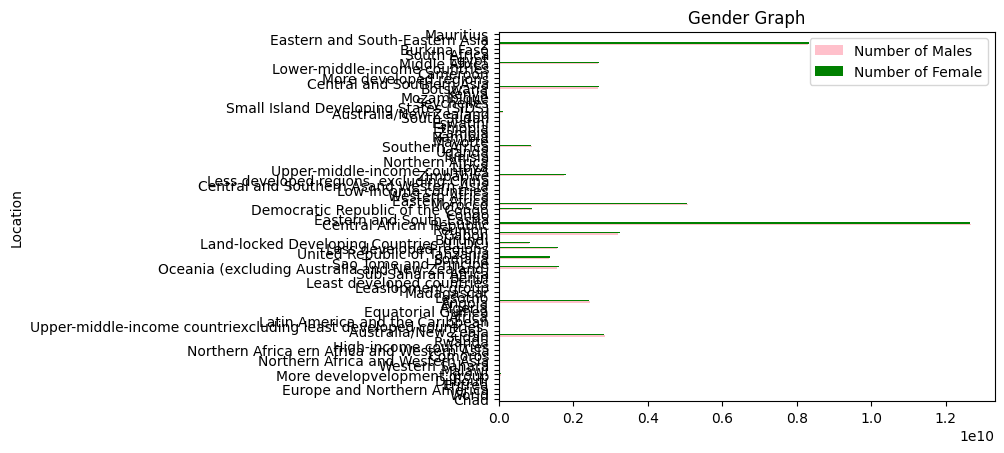

In [ ]:
df = pd.DataFrame({'Number of Males': list(grouped_pop_PopMale.sort_values(by='Location').reset_index()['Male']),
                   'Number of Female': list(grouped_pop_PopFemale.sort_values(by='Location').reset_index()['Female'])},
                  index=grouped_pop_PopMale['Location'])

df.plot(kind="barh", title="Gender Graph",
        color={"green", "pink"})

In [ ]:
grouped_pop_PopMale.merge(grouped_pop_PopFemale, on = 'Location', how = 'outer')

,Location,Male,Female
0,Chad,2.404025e+05,2.424827e+05
1,World,8.307330e+09,8.328760e+09
2,Europe and Northern America,1.552204e+09,1.608619e+09
3,Eritrea,7.683719e+04,7.952081e+04
4,Djibouti,2.447131e+04,2.489421e+04
...,...,...,...
71,South Africa,1.223210e+06,1.270519e+06
72,Burkina Faso,3.787686e+04,3.592243e+04
73,2,5.000000e+00,3.522823e+04
74,Eastern and South-Eastern Asia,2.447452e+09,2.427179e+09


In [ ]:
grouped_fer_asfr = fer.groupBy("Location").agg(sum("ASFR").alias('ASFR')).toPandas()
grouped_fer_pasfr = fer.groupBy("Location").agg(sum("ASFR").alias('PASFR')).toPandas()

<Axes: >

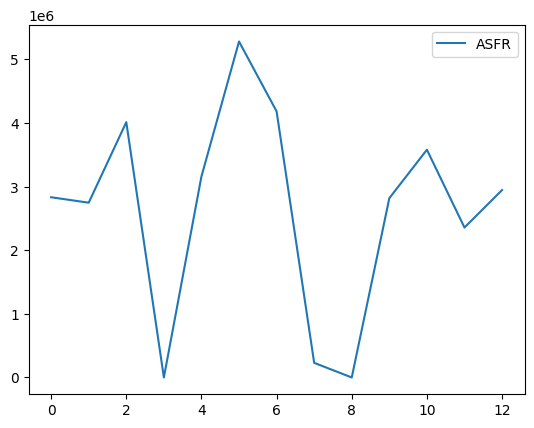

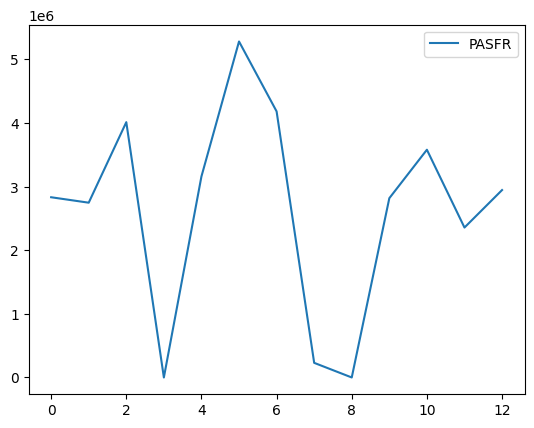

In [ ]:
grouped_fer_asfr.plot()
grouped_fer_pasfr.plot()

In [ ]:
spark.stop()